# Universal Automated Tutor

## 0: Data Import + Cleaning

In [1]:
import pandas as pd
import numpy as np 
import random
import fitter
from fitter import Fitter
import matplotlib.pyplot as plt

In [2]:
# Read in the CSVs, select variables, combine
raw_data04 = pd.read_csv("2004-WPI-Assistments-Math.csv",low_memory=False)
raw_data056 = pd.read_csv("2005-06-WPI-Assistments-Math.csv",low_memory=False)
raw_data056["problem_id"] = raw_data056["problem_id"] + max(raw_data04.problem_id)
raw_data = pd.concat([raw_data056,raw_data04])
data = raw_data[["stud_id","duration","student_response_type","problem_id","step","attempt_num",
             "last_attempt","outcome","input","feedback"]]
data.reset_index(drop=True, inplace=True)

# Create binary variables for hint, correct, incorrect
data.loc[:,"hint"] = np.where(data["outcome"] == "HINT",1,0)
data.loc[:,"correct"] = np.where(data["outcome"] == "CORRECT",1,0)
data.loc[:,"incorrect"] = np.where(data["outcome"] == "INCORRECT",1,0)

# Filter + clean data
data = data[data["duration"] != '.']
data["duration"] = data["duration"].astype(np.float64)

C:\Users\C22Cameron.Cubra\Anaconda4\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\C22Cameron.Cubra\Anaconda4\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## 1: Distribution Creation

In [3]:
# Docstring Example

''' Summary or Description of the Function

    Parameters:
    argument1 (int): Description of arg1

    Returns:
    int: Returning value
'''

' Summary or Description of the Function\n\n    Parameters:\n    argument1 (int): Description of arg1\n\n    Returns:\n    int: Returning value\n'

In [4]:
def chi2lower(x):
    ''' Calculates the chi-squared distribution lower bound

    Parameters:
    x (float64): A # of incorrect, # of hints, or a duration

    Returns:
    float64: Returns the lower bound of the chi-squared distribution
    '''
    return np.mean(x) - np.std(x)/4


def chi2upper(x):
    ''' Calculates the chi-squared distribution upper bound

    Parameters:
    x (float64): A # of incorrect, # of hints, or a duration

    Returns:
    float64: Returns the upper bound of the chi-squared distribution
    '''
    return np.mean(x) + np.std(x)/2



In [6]:
# group the problems and students together to get the sum of each variable for each question
df = data[["problem_id", "duration", "hint", "stud_id","incorrect"]].groupby(["problem_id","stud_id"]).sum()
problemDistsLower = df.groupby(["problem_id"]).agg(chi2lower)
problemDistsUpper = df.groupby(["problem_id"]).agg(chi2upper)
problemDistsLower.rename(columns={'duration': 'durationLower', 'hint': 'hintLower', 'incorrect': 'incorrectLower'}, inplace=True)
problemDistsUpper.rename(columns={'duration': 'durationUpper', 'hint': 'hintUpper', 'incorrect': 'incorrectUpper'}, inplace=True)
problemDists = pd.concat([problemDistsLower, problemDistsUpper], axis=1)

# Create given student's mean
studentEV = df.groupby(["stud_id"]).mean()

In [7]:
# Grouping data to create the data frame df which will be used to create problem distributions for duration, number of hints, and number of incorrects
dists_df = data[["problem_id", "duration", "hint", "stud_id","incorrect"]].groupby(["problem_id","stud_id"]).sum()
dists_df.to_csv("C:/Users/C22Cameron.Cubra/OneDrive - usafa.edu/Desktop/Capstone/df.csv")
dists_df = pd.read_csv("C:/Users/C22Cameron.Cubra/OneDrive - usafa.edu/Desktop/Capstone/df.csv", index_col = False)

In [27]:
# Creating dictionary of dictionaries that contains keys for each distributions (duration, number of hints, and number of incorrects)
# data and sub keys with each problem 
prob_duration_dists = {}
types = ['duration', 'hint', 'incorrect']
problems = dists_df['problem_id'].unique()   # 1342 problems
for dist in types:
    prob_duration_dists[dist] = {}
    for prob_id in problems:
        duration_array = dists_df.loc[dists_df['problem_id'] == prob_id,dist]
        prob_duration_dists[dist][prob_id] = duration_array

1342


         sumsquare_error          aic         bic  kl_div
expon           0.000052  1698.096492 -710.156002     inf
beta            0.000053  1683.520737 -701.350756     inf
norm            0.000074  1857.379593 -692.086564     inf
triang          0.000074  1552.629426 -688.061015     inf
lognorm         0.000106  1927.078413 -669.635552     inf
{'expon': {'loc': 9.0, 'scale': 342.6730769230769}}
         sumsquare_error          aic         bic  kl_div
lognorm         0.000208  1652.194078 -423.420164     inf
gamma           0.000245  1760.908693 -417.541486     inf
chi2            0.000256  1656.992095 -416.011430     inf
beta            0.000265  2185.259255 -411.097735     inf
expon           0.000393  1692.586866 -404.119211     inf
{'lognorm': {'s': 1.6178805066217035, 'loc': 9.115754833204644, 'scale': 50.15601086366324}}
        sumsquare_error          aic          bic  kl_div
expon          0.001094  1487.185960 -1021.890071     inf
gamma          0.001170  1484.377495 -1011.

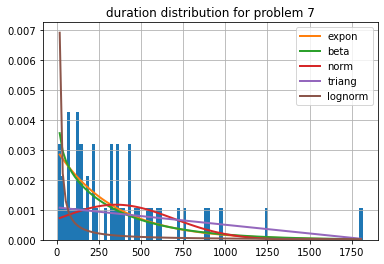

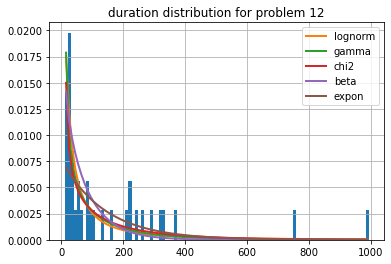

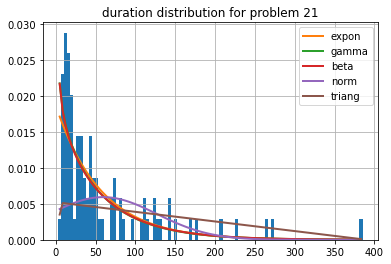

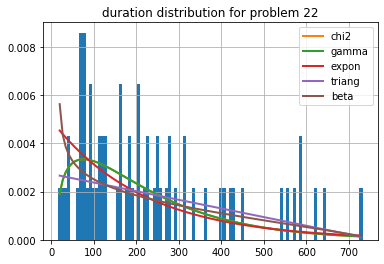

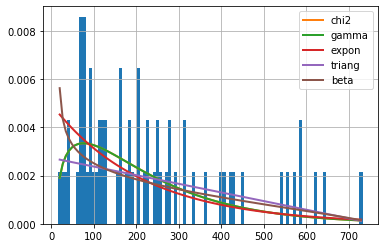

In [9]:
# Building distributions from data above
i = 0
for dist, problem in prob_duration_dists.items():
    for prob_id in problems:
        title = dist + " distribution for problem "+ str(prob_id)
        if i == 4:
            break
        x = problem[prob_id]
        
        # The distributions being tried to fit
        dists = ['expon', 'beta', 'gamma', 'chi2',
                 'lognorm', 'norm', 'triang']

        f = Fitter(x, distributions=dists)
        f.fit()
        f.summary()
        plt.title(title)
        plt.figure()
        # The plot indicated the best fit as the first in the legend
        print(f.summary())
        print(f.get_best())
        i += 1

In [22]:
# Grouping data to create the data frame df which will be used to create student distributions for duration, number of hints, and number of incorrects
student_dists_df = data[["duration", "hint", "stud_id","incorrect"]].groupby(["stud_id"]).sum()
student_dists_df.to_csv("C:/Users/C22Cameron.Cubra/OneDrive - usafa.edu/Desktop/Capstone/sdf.csv")
student_dists_df = pd.read_csv("C:/Users/C22Cameron.Cubra/OneDrive - usafa.edu/Desktop/Capstone/sdf.csv", index_col = False)

In [23]:
def how_many_problems(x):
    '''
    '''
    return len(x.unique())

In [24]:
student_number_of_problems = data[[ "stud_id","problem_id"]].groupby(["stud_id"]).agg(how_many_problems)
print(student_number_of_problems['problem_id'])
print(student_dists_df)

stud_id
Stu_0012ae7d5d1993619f0bad91630b7c79      2
Stu_00176143fc2991346939888160a9b1ce     37
Stu_001c92cd0ee0ea92a7ec2c5d027ab034      3
Stu_001d187b1b375fe98b88696b250177f0     81
Stu_00291360813ec3b3bc1133a40e2e7590     39
                                       ... 
Stu_ffbeb30c744d4c4db5352b708773eca4      3
Stu_ffce1f362b212a39ef47c8303f33c69d      2
Stu_ffdef7d1961079fb05dc295e8ab7592e     70
Stu_ffdf43fb9857c337d0a484d80ad7c405      8
Stu_fff5c8fc1e1e08cfd72a0e5122b547d4    118
Name: problem_id, Length: 4033, dtype: int64
                                   stud_id   duration  hint  incorrect
0     Stu_0012ae7d5d1993619f0bad91630b7c79    854.000     2          1
1     Stu_00176143fc2991346939888160a9b1ce   6342.000    35         63
2     Stu_001c92cd0ee0ea92a7ec2c5d027ab034    943.000     0         20
3     Stu_001d187b1b375fe98b88696b250177f0  13237.999   213        146
4     Stu_00291360813ec3b3bc1133a40e2e7590  16671.000    57        137
...                                  

In [25]:
# Creating dictionary of dictionaries that contains keys for each student and sub keys with each
# distribution data (duration, number of hints, and number of incorrects)
student_duration_dists = {}
students = student_dists_df['stud_id'].unique()
for (columnName, columnData) in student_dists_df.iteritems():
    if columnName == 'stud_id':
        continue
    values = []
    for i, stud in enumerate(columnData):
        values.append(stud/student_number_of_problems['problem_id'][i])
    student_duration_dists[columnName] = values


        sumsquare_error          aic           bic  kl_div
chi2           0.000011  3300.804872 -79560.892693     inf
beta           0.000012  3205.516742 -79246.759609     inf
norm           0.000030  7719.342496 -75447.968203     inf
expon          0.000050  2310.494554 -73401.625638     inf
triang         0.000085  1641.513237 -71250.797882     inf
{'chi2': {'df': 5.247225300762944, 'loc': -7.080479906652661, 'scale': 41.414681793349004}}
         sumsquare_error          aic           bic  kl_div
expon           0.006146  1698.941809 -54002.427728     inf
lognorm         0.027052  1286.984423 -48017.168369     inf
beta            0.030564  1671.541917 -47516.657637     inf
chi2            0.056342  1324.713929 -45058.328746     inf
gamma           0.216326  2122.581373 -39632.534273     inf
{'expon': {'loc': 0.0, 'scale': 1.844152793985426}}
         sumsquare_error           aic           bic  kl_div
lognorm         0.018066   2471.650676 -49645.550357     inf
beta            0.03

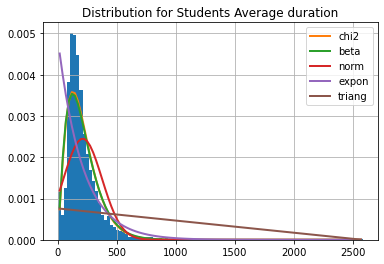

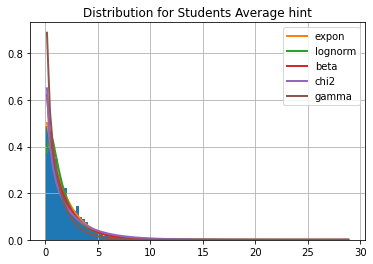

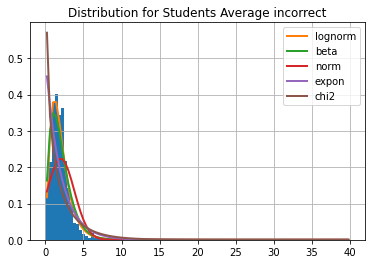

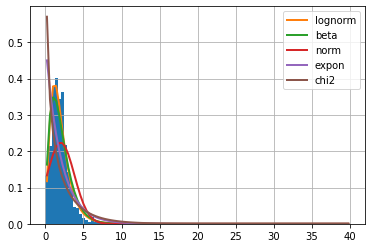

In [26]:
# Building distributions from data above
i = 0
for dist, values in student_duration_dists.items():
    title = "Distribution for Students Average "+ dist
    if i == 3:
        break
    x = values

    # The distributions being tried to fit
    dists = ['expon', 'beta', 'gamma', 'chi2',
             'lognorm', 'norm', 'triang']

    f = Fitter(x, distributions=dists)
    f.fit()
    f.summary()
    plt.title(title)
    plt.figure()
    # The plot indicated the best fit as the first in the legend
    print(f.summary())
    print(f.get_best())
    i += 1

## 2: Student Class

In [6]:
class Student:
    
    
    def __init__(self, data):
        self.data = data
        self.means = 0
        self.problem = ""

        
    def updateStudent(self, lastQ):
        self.data = self.data.append(lastQ)
        self.means = self.data.mean()
        self.duration = self.means.duration
        self.incorrect = self.means.incorrect
        self.hint = self.means.hint
        
    def nextQ(self):
        # Determines a viable next question
        EVdur = self.duration
        EVinc = self.incorrect
        EVhint = self.hint
        viableProbs = problemDists[(EVdur < problemDists["durationUpper"])  & (EVhint < problemDists["hintUpper"]) & \
                                   (problemDists["incorrectLower"] > EVinc)]
        problemNum = random.choice(viableProbs.index.values.tolist())
        self.problem = df[df["problem_id"]==problemNum].iloc[0][0].split(':')[-1].split("?")[0] + "?"

## 3: Example Run Through

Pseudo Code
studentData = Pretest data
Pretest data will include entries with "step", "problem_id", "duration", "hint", "incorrect", "correct"
student = Student(studentData)

In [7]:
# Example
stud = "Stu_fe96fe63d83aa63c4ec667167fc7f1ce"
df = data[["step", "problem_id", "stud_id","duration", "hint", "incorrect", "correct"]]
newdf = df[df["stud_id"] == stud]
studentData = newdf.iloc[0:10,:]

studentData

,step,problem_id,stud_id,duration,hint,incorrect,correct
1266120,Step0:3761:Harry measured all but one angle of...,3761,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,90.0,1,0,0
1266121,Step1:3762:How many angles are there in a pent...,3761,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,37.0,0,1,0
1266122,Step1:3762:How many angles are there in a pent...,3761,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,4.0,0,0,1
1266123,Step0:3761:Harry measured all but one angle of...,3761,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,246.0,1,0,0
1266124,Step1:3762:How many angles are there in a pent...,3761,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,6.0,0,0,1
1266125,Step3:3764:What is the measure of the only ang...,3761,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,29.0,0,0,1
1266126,Step0:193:(0.2)(0.2)(0.2) is equal to which of...,193,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,37.0,0,0,1
1266127,Step0:113:Figure ABCD is translated so that th...,113,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,65.0,1,0,0
1266128,Step1:114:Look at the figure above. Let s find...,113,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,88.0,1,0,0
1266129,Step1:114:Look at the figure above. Let s find...,113,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,21.0,1,0,0


In [8]:
# Initializing a student
student = Student(studentData)

# questionData represents their next action from the GUI (we will be passed this)
questionData = newdf.iloc[11:13,:]

# If the person gets the problem right, then send the questionData to the student to update and choose next Q
if questionData.correct.isin([1]).any():
    student.updateStudent(questionData)
    student.nextQ()

# Question that is sent to the interface next:
print(student.problem)

1. What is the circumference, in centimeters of gear B?


# What is left to finish model?

- Need to find correct answers
- Need to find images
- Need to figure out how to get through steps
- Need to format answer box to accept all close answers

In [9]:
correct = data[data['outcome'] == "CORRECT"]

In [10]:
correct.problem_id.unique()

array([13450, 12489,  6113, ...,  2275,  2274,  3678], dtype=int64)

In [11]:
info = data.groupby('outcome')['problem_id'].unique()['CORRECT']

In [12]:
truth_series = data.problem_id.isin(info)

In [13]:
g = data[truth_series]
g

,stud_id,duration,student_response_type,problem_id,step,attempt_num,last_attempt,outcome,input,feedback,hint,correct,incorrect
0,Stu_0012ae7d5d1993619f0bad91630b7c79,576.0,HINT_REQUEST,13603,"Step0:8788:Lines m and n are parallel, what is...",1.0,1.0,HINT,NaN,System displays first scaffold,1,0,0
1,Stu_0012ae7d5d1993619f0bad91630b7c79,75.0,HINT_REQUEST,13603,Step1:8792:What is the measure of angle 2? SYSTEM,1.0,0.0,HINT,NaN,Lines m and n are parallel and intersected by ...,1,0,0
2,Stu_0012ae7d5d1993619f0bad91630b7c79,37.0,ATTEMPT,13603,Step1:8792:What is the measure of angle 2? SYSTEM,2.0,1.0,INCORRECT,55,That is not correct. Try again.,0,0,1
3,Stu_0012ae7d5d1993619f0bad91630b7c79,166.0,ATTEMPT,13450,Step0:8635:Jacqueline is a runner who hopes to...,1.0,1.0,CORRECT,9 miles,NaN,0,1,0
4,Stu_00176143fc2991346939888160a9b1ce,14.0,HINT_REQUEST,12489,Step0:7674:Lee correctly answered 26 out of 51...,1.0,1.0,HINT,NaN,System displays first scaffold,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266395,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,99.0,HINT_REQUEST,566,"Step2:568:Good, there are 4 rectangles of size...",3.0,1.0,HINT,NaN,The same rectangle of size 1 can be used in di...,1,0,0
1266396,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,28.0,ATTEMPT,698,Step0:698:The table above shows the annual sal...,1.0,0.0,INCORRECT,"C. $27,000",The difference has to be positive.,0,0,1
1266397,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,6.0,ATTEMPT,698,Step0:698:The table above shows the annual sal...,2.0,1.0,INCORRECT,"A. $25,500",NaN,0,0,1
1266398,Stu_fe96fe63d83aa63c4ec667167fc7f1ce,103.0,ATTEMPT,566,Step0:566:How many rectangles are there in Fig...,1.0,1.0,INCORRECT,9,NaN,0,0,1


In [14]:
df[df["problem_id"]==7].step

689070     Step0:7:Figure ABCD is translated so that the ...
689071     Step1:8:First let s find how point A is relate...
689150     Step0:7:Figure ABCD is translated so that the ...
706712     Step0:7:Figure ABCD is translated so that the ...
706713     Step1:8:First let s find how point A is relate...
                                 ...                        
1239510    Step3:10:Point B is related to the image of po...
1239511    Step3:10:Point B is related to the image of po...
1239512    Step3:10:Point B is related to the image of po...
1239513    Step3:10:Point B is related to the image of po...
1239514    Step4:11:What is the y-coordinate of the image...
Name: step, Length: 616, dtype: object

Histograms of each problem and student. how many Hint, duration, number of incorrect before correct. Fit/test distributions